Background

Diabetes is a major global health challenge, and early detection greatly increases the chances of successful treatment.
In this project, I work with the Pima Indians Diabetes dataset, which includes 768 samples and several clinical measurements such as glucose level, BMI, insulin, pregnancies, and age.
The objective is to build a machine learning model that can predict whether a patient is likely to develop diabetes based on these medical features.

In [ ]:
# !mkdir -p data
# !wget -O data/diabetes.csv "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"

--2025-11-17 00:22:13--  https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23873 (23K) [text/plain]
Saving to: ‘data/diabetes.csv’

data/diabetes.csv   100%[===================>]  23.31K  --.-KB/s    in 0.02s   

2025-11-17 00:22:14 (1.23 MB/s) - ‘data/diabetes.csv’ saved [23873/23873]



In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Load CSV
df = pd.read_csv("../data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Quick overview
df.info()

# not null values in all columns but let's check descriptive statistics

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [18]:
print(df.describe())

# insulina has mean of 79.80 but median of 30.5, so it is very right skewed

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

<Axes: >

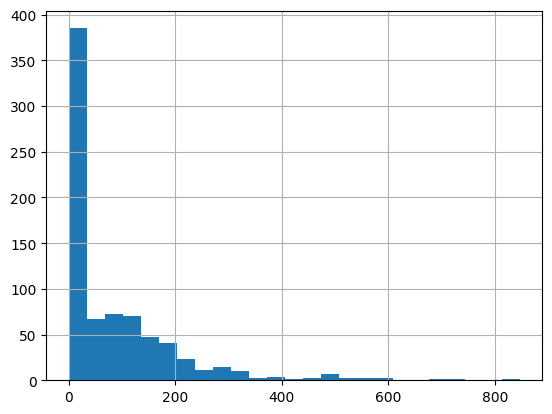

In [19]:
# Lets check Insulin distribution plotting histogram
df['Insulin'].hist(bins=25)

# This is a strong right skew, meaning most people have low insulin (median: 30.500000), but there are many very large outliers (mean: 79.799479), reaching up to 846.

In [20]:
# Lets check number of zeros in each column
(df == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [ ]:
# So, Glucose, BloodPressure, SkinThickness, Insulin, and BMI have zeros, which is not possible for these medical measurements. 
# These zeros likely represent missing values that need to be addressed before modeling.

# Columns where zero means missing
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN
df[invalid_zero_cols] = df[invalid_zero_cols].replace(0, np.nan)

# Median imputation for missing values
df[invalid_zero_cols] = df[invalid_zero_cols].fillna(df[invalid_zero_cols].median())

df.isna().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
# Lets check class balance of the target variable 'Outcome'
print(df['Outcome'].value_counts(normalize=True))

# This is slightly imbalanced. 
# About 65% are 0 (no diabetes)
# About 35% are 1 (diabetes)

# Later we can consider:
# class_weight='balanced' in tree models
# Resampling techniques like SMOTE - to experiment

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


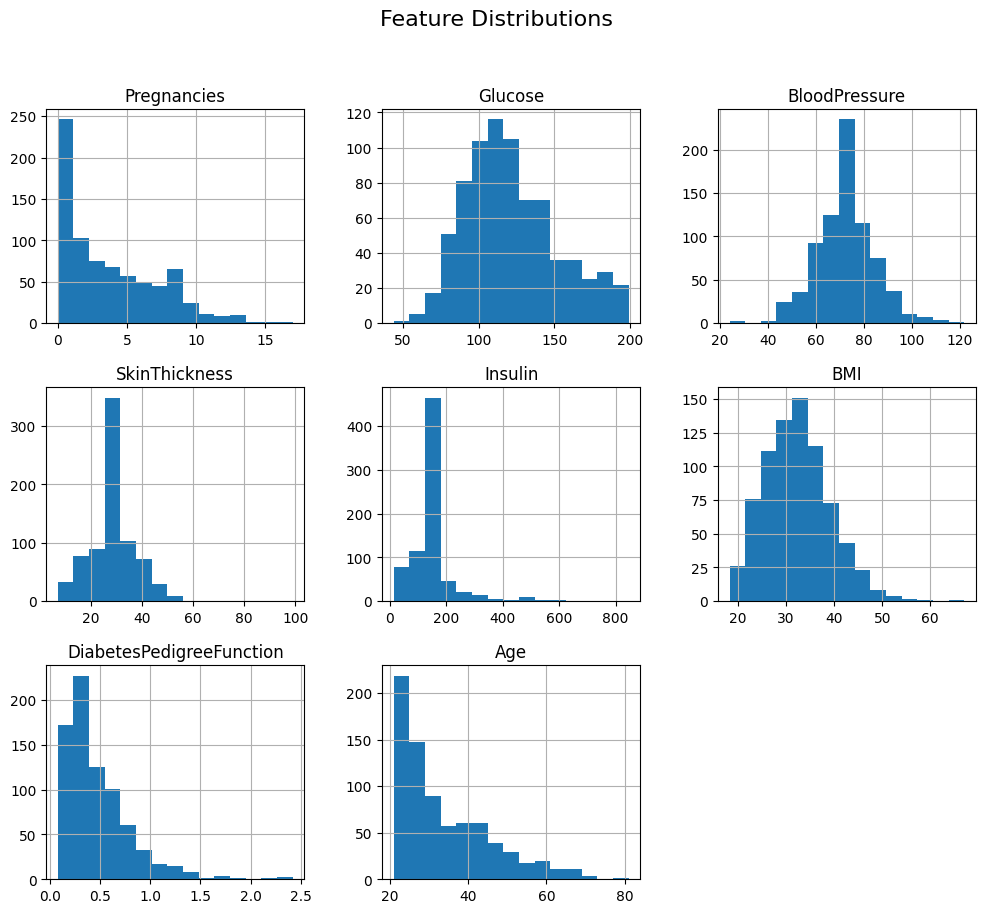

In [27]:
# Visualizations

numeric_features = df.columns[:-1]  # all except 'Outcome'

# Histograms
numeric_features = df.columns[:-1]  # exclude target
df[numeric_features].hist(figsize=(12,10), bins=15)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# # Correlation heatmap
# plt.figure(figsize=(8,6))
# sns.heatmap(df.corr(), annot=True)
# plt.show()


Insulin: Most values are between ~0–200, with median around 30.

- A few extreme values go up to 800+. This is why the mean is much higher than median → right-skewed distribution.

In [29]:
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.348958  
std      6.875177                  0.331329   11.760232    0.476951  
min     18.200000                  

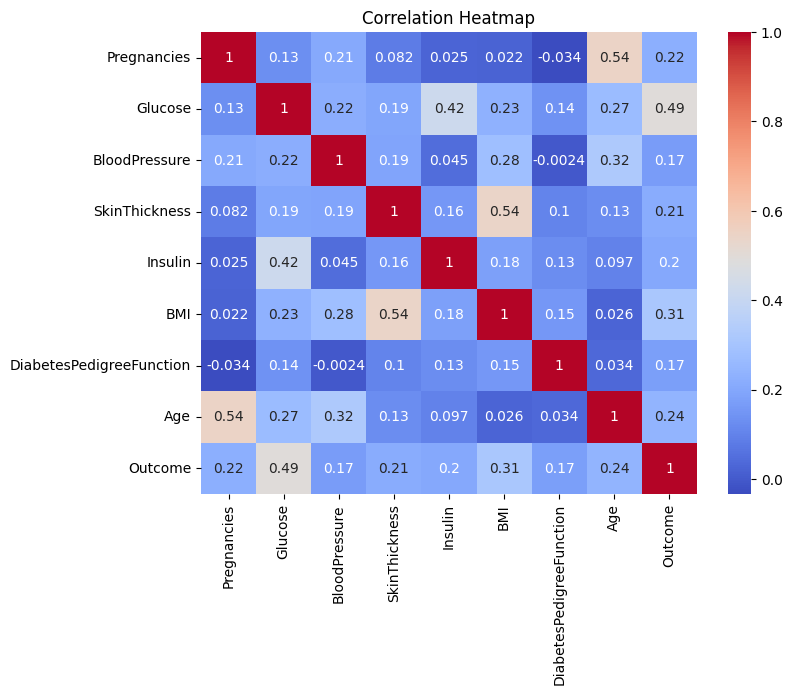

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Weaknesses correlations:
# Pregnancies and Age have weak correlation: 0.54
# SkinThickness and BMI have weak correlations: 0.54
# Glucose and Insulin have weak correlation: 0.42

In [32]:
# Save cleaned file (no cleaning needed for this dataset)
df.to_csv("../data/diabetes_clean.csv", index=False)

In [ ]:
# End of EDA